In [10]:
# Imports & Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
np.random.seed(11)
plt.rcParams['figure.figsize'] = (8, 5)

## Data: Load or Generate
Check for existing CSV; if missing, generate synthetic data with some NaNs.

In [11]:
data_dir = Path('data')
data_dir.mkdir(parents=True, exist_ok=True)
csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    df = pd.read_csv(csv_path)
else:
    x = np.linspace(0, 10, 80)
    y = 2.5 * x + 3 + np.random.normal(0, 3, size=x.size)
    df = pd.DataFrame({'x': x, 'y': y})
    # Introduce random missing values
    df.loc[np.random.choice(df.index, 5), 'y'] = np.nan
    df.to_csv(csv_path, index=False)

df.head()

,x,y
0,0.000000,8.248364
1,0.126582,2.458237
2,0.253165,2.179216
3,0.379747,-4.010589
4,0.506329,4.240969


## Visual Check for Missing Values
Inspect data quality before modeling.

Missing values: {'x': 0, 'y': 4}


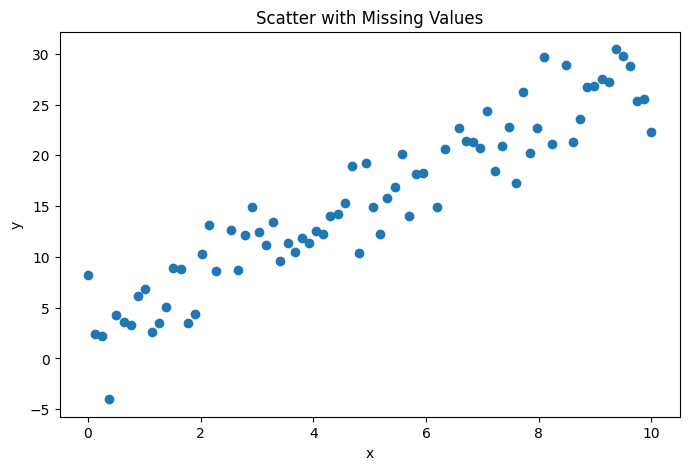

In [12]:
print('Missing values:', df.isna().sum().to_dict())
plt.scatter(df['x'], df['y'])
plt.title('Scatter with Missing Values')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Scenario 1: Fill Method Assumptions
📌 Compare Mean Fill vs Median Fill vs Dropping Missing Data

In [13]:
df_mean = df.copy()
print(df['y'].mean())
df_mean['y'] = df_mean['y'].fillna(df['y'].mean())

df_med = df.copy()
print(df['y'].median())
df_med['y'] = df_med['y'].fillna(df['y'].median())

print(np.nan)
df_drop = df.dropna()
print("")

def fit_lin(d):
    m = LinearRegression().fit(d[['x']], d['y'])
    return float(m.coef_[0]), float(m.intercept_)

s_mean, i_mean = fit_lin(df_mean)
s_med, i_med = fit_lin(df_med)
s_drop, i_drop = fit_lin(df_drop)

print('Mean Fill:', s_mean, i_mean)
print('Median Fill:', s_med, i_med)
print('Drop NA:', s_drop, i_drop)



15.514463575309264
14.93608621181718
nan

Mean Fill: 2.497427696285113 3.0273250938836984
Median Fill: 2.4946429163868173 3.012330125200572
Drop NA: 2.5781626691021877 2.7352961814916252


## Scenario 2:  Linear vs Polynomial Regression

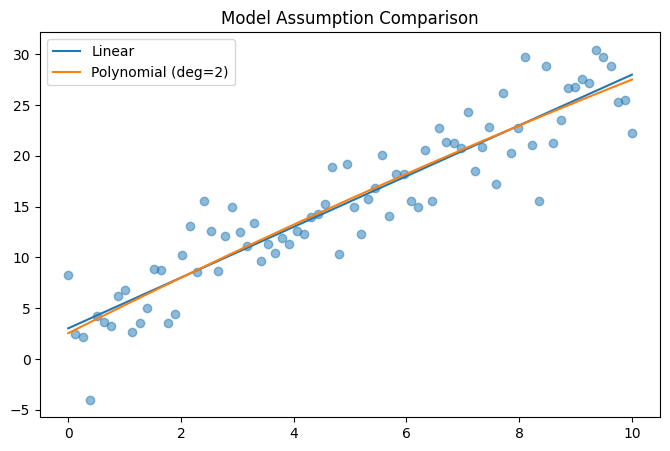

In [15]:
X = df_mean[['x']]
y = df_mean['y']

lin = LinearRegression().fit(X, y)
poly = make_pipeline(PolynomialFeatures(2), LinearRegression()).fit(X, y)

plt.scatter(X, y, alpha=0.5)
plt.plot(X, lin.predict(X), label='Linear')
plt.plot(X, poly.predict(X), label='Polynomial (deg=2)')
plt.legend()
plt.title('Model Assumption Comparison')
plt.show()

## Scenario 3: Gaussian vs Bootstrapped Confidence Intervals
📌 Compare distributional assumptions for prediction uncertainty

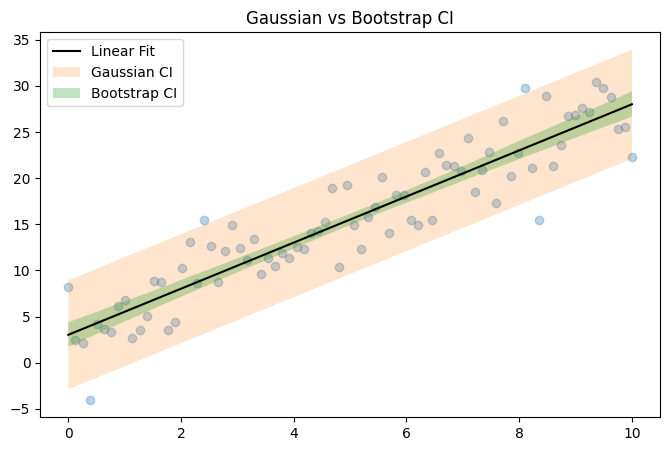

In [16]:
# Predict on full X
y_hat = lin.predict(X)
resid = y - y_hat
sigma = resid.std()

# Gaussian CI (over X, not confidence interval of X itself)
# Builds a 95% confidence interval using ±1.96 × standard deviation.
# Assumes prediction errors are normally distributed.
# This is a quick and theoretical method — doesn't use resampling.
ci_gauss = (y_hat - 1.96*sigma, y_hat + 1.96*sigma)

# Bootstrap CI
boot_preds = []
for _ in range(500):
    #Take a bootstrapped sample of rows from df_mean: a full-size sample with replacement.
    #Introduces variation like a real-world sampling error.   
    # fac=1 => 100% of the original dataset size, (but with replacement)
    sample = df_mean.sample(frac=1, replace=True)
    m = LinearRegression().fit(sample[['x']], sample['y'])
    boot_preds.append(m.predict(X))  # X is 200-length
boot_preds = np.array(boot_preds)

# For each x value, compute the 2.5th and 97.5th percentiles across all 500 predictions.
# This gives a 95% bootstrap confidence interval for each point in X.
ci_boot = (
    np.percentile(boot_preds, 2.5, axis=0),
    np.percentile(boot_preds, 97.5, axis=0)
)

# Plot
plt.scatter(X, y, alpha=0.3)
plt.plot(X['x'], y_hat, color='black', label='Linear Fit')
plt.fill_between(X['x'], ci_gauss[0], ci_gauss[1], alpha=0.2, label='Gaussian CI')
plt.fill_between(X['x'], ci_boot[0],  ci_boot[1],  alpha=0.3, label='Bootstrap CI')
plt.legend()
plt.title('Gaussian vs Bootstrap CI')
plt.show()

## 2. Baseline Fit

We define the **baseline model** as: mean imputation on `y` + **Linear Regression** on `x` using a scikit-learn `Pipeline` (with a scaler for good practice).  
Metrics reported: **R²**, **RMSE**, **MAE**. Residuals are stored for later diagnostics.


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Baseline = mean-imputed df (df_mean) + Linear Regression
X_base = df_mean[['x']].copy()
y_base = df_mean['y'].copy()

baseline_pipe = Pipeline([('scaler', StandardScaler()),
                          ('lin', LinearRegression())])
baseline_pipe.fit(X_base, y_base)

yhat_base = baseline_pipe.predict(X_base)
resid_base = y_base.values - yhat_base

r2_base = r2_score(y_base, yhat_base)
rmse_base = float(np.sqrt(mean_squared_error(y_base, yhat_base)))
mae_base = float(mean_absolute_error(y_base, yhat_base))

print(f"Baseline (Mean-Impute + Linear) — R2: {r2_base:.4f} | RMSE: {rmse_base:.4f} | MAE: {mae_base:.4f}")

Baseline (Mean-Impute + Linear) — R2: 0.8560 | RMSE: 2.9945 | MAE: 2.3803


## 3. Bootstrap (≥ 500 resamples)

We bootstrap the data **with replacement** 1000 times to estimate uncertainty for:
- **RMSE** (performance metric)  
- **Prediction curve** on a grid of `x` values (95% CI band)

We visualize the **prediction uncertainty band** and report the **RMSE CI**.


Bootstrap RMSE (1000x) — mean: 3.0355 | 95% CI: [2.9956, 3.1394]


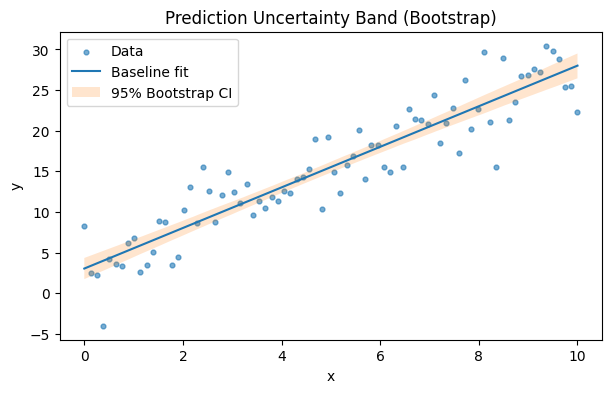

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)
B = 1000  # number of bootstrap resamples (>= 500)

# Prepare grid for prediction bands
x_min, x_max = float(X_base['x'].min()), float(X_base['x'].max())
x_grid = np.linspace(x_min, x_max, 200)
X_grid = pd.DataFrame({'x': x_grid})

rmse_boot = np.empty(B, dtype=float)
yhat_grid_boot = np.empty((B, X_grid.shape[0]), dtype=float)

for b in range(B):
    idx = rng.integers(low=0, high=len(X_base), size=len(X_base))  # resample indices with replacement
    X_b = X_base.iloc[idx].reset_index(drop=True)
    y_b = y_base.iloc[idx].reset_index(drop=True)

    pipe_b = Pipeline([('scaler', StandardScaler()), ('lin', LinearRegression())])
    pipe_b.fit(X_b, y_b)

    # Apparent RMSE on original sample (could also use OOB logic if desired)
    yhat_b = pipe_b.predict(X_base)
    rmse_boot[b] = np.sqrt(mean_squared_error(y_base, yhat_b))

    # Store prediction on grid for CI band
    yhat_grid_boot[b, :] = pipe_b.predict(X_grid)

# 95% percentile CI for RMSE
rmse_lo, rmse_hi = np.percentile(rmse_boot, [2.5, 97.5])
print(f"Bootstrap RMSE (1000x) — mean: {rmse_boot.mean():.4f} | 95% CI: [{rmse_lo:.4f}, {rmse_hi:.4f}]")

# 95% CI band for predictions
yhat_grid_lo = np.percentile(yhat_grid_boot, 2.5, axis=0)
yhat_grid_hi = np.percentile(yhat_grid_boot, 97.5, axis=0)

# Fit baseline once for center line
yhat_grid_center = baseline_pipe.predict(X_grid)

# Plot: data, baseline fit, and CI band
plt.figure(figsize=(7,4))
plt.scatter(X_base['x'], y_base, s=12, alpha=0.6, label='Data')
plt.plot(x_grid, yhat_grid_center, label='Baseline fit')
plt.fill_between(x_grid, yhat_grid_lo, yhat_grid_hi, alpha=0.2, label='95% Bootstrap CI')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Prediction Uncertainty Band (Bootstrap)')
plt.legend()
plt.show()

## 4. Scenario Comparison (≥ 2)

We compare **three** dimensions:
1. **Imputation strategy**: mean vs median vs drop-NA  
2. **Model form**: linear vs polynomial (degree=2)  
3. **Noise distribution**: Gaussian vs t-distribution (fresh simulated datasets)

For each scenario we compute **R² / RMSE / MAE** and show how results shift.


In [19]:
from sklearn.preprocessing import PolynomialFeatures

def fit_eval(pipe, X, y, name):
    pipe.fit(X, y)
    yhat = pipe.predict(X)
    return {
        'scenario': name,
        'R2': r2_score(y, yhat),
        'RMSE': float(np.sqrt(mean_squared_error(y, yhat))),
        'MAE': float(mean_absolute_error(y, yhat))
    }

results = []

# (a) Imputation: mean / median / drop
pipe_lin = Pipeline([('scaler', StandardScaler()), ('lin', LinearRegression())])

X_mean, y_mean = df_mean[['x']], df_mean['y']
results.append(fit_eval(pipe_lin, X_mean, y_mean, 'Impute: Mean + Linear'))

X_med, y_med = df_med[['x']], df_med['y']
results.append(fit_eval(pipe_lin, X_med, y_med, 'Impute: Median + Linear'))

X_drop, y_drop = df_drop[['x']], df_drop['y']
results.append(fit_eval(pipe_lin, X_drop, y_drop, 'Drop-NA + Linear'))

# (b) Model: linear vs polynomial (on mean-imputed data for fairness)
pipe_poly2 = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                       ('scaler', StandardScaler()),
                       ('lin', LinearRegression())])
results.append(fit_eval(pipe_poly2, X_mean, y_mean, 'Impute: Mean + Poly(deg=2)'))

# (c) Distribution: Gaussian vs t noise (fresh data, same x grid)
n = 300
x_scn = np.linspace(x_min, x_max, n)
rng2 = np.random.default_rng(2024)
true_slope, true_intercept = 2.0, 1.0

eps_g = rng2.normal(0, 1.0, size=n)
y_g = true_slope * x_scn + true_intercept + eps_g

eps_t = rng2.standard_t(df=3, size=n)
y_t = true_slope * x_scn + true_intercept + eps_t

df_g = pd.DataFrame({'x': x_scn, 'y': y_g})
df_tt = pd.DataFrame({'x': x_scn, 'y': y_t})

results.append(fit_eval(pipe_lin, df_g[['x']], df_g['y'], 'Gaussian noise + Linear'))
results.append(fit_eval(pipe_lin, df_tt[['x']], df_tt['y'], 't(df=3) noise + Linear'))

# Summary table
scn_table = pd.DataFrame(results)
display(scn_table)  # if in notebook environment
print(scn_table)    # plain print fallback

# Optional: simple bar-like text output
best = scn_table.sort_values('RMSE').head(3)
print('\nTop-3 by RMSE (lower is better):\n', best[['scenario','RMSE','R2','MAE']])

,scenario,R2,RMSE,MAE
0,Impute: Mean + Linear,0.855969,2.994547,2.380275
1,Impute: Median + Linear,0.853843,3.016949,2.395571
2,Drop-NA + Linear,0.883640,2.761488,2.194632
3,Impute: Mean + Poly(deg=2),0.856773,2.986173,2.368782
4,Gaussian noise + Linear,0.972336,0.980273,0.762331
5,t(df=3) noise + Linear,0.922347,1.678395,1.151139


                     scenario        R2      RMSE       MAE
0       Impute: Mean + Linear  0.855969  2.994547  2.380275
1     Impute: Median + Linear  0.853843  3.016949  2.395571
2            Drop-NA + Linear  0.883640  2.761488  2.194632
3  Impute: Mean + Poly(deg=2)  0.856773  2.986173  2.368782
4     Gaussian noise + Linear  0.972336  0.980273  0.762331
5      t(df=3) noise + Linear  0.922347  1.678395  1.151139

Top-3 by RMSE (lower is better):
                   scenario      RMSE        R2       MAE
4  Gaussian noise + Linear  0.980273  0.972336  0.762331
5   t(df=3) noise + Linear  1.678395  0.922347  1.151139
2         Drop-NA + Linear  2.761488  0.883640  2.194632


## 5. Subgroup Diagnostics

We split the data into two subgroups by the median of `x`:  
- **Segment A**: `x` below median  
- **Segment B**: `x` at/above median  

We compute residual metrics per subgroup to identify hidden failures or confirm stability.


            n      RMSE       MAE  R2_local  Resid_Mean  Resid_Std
segment                                                           
A_lowX   40.0  2.893605  2.240463  0.660605    0.165683   2.925659
B_highX  40.0  3.092196  2.520086  0.602148   -0.165683   3.127090


/var/folders/mm/zd5mx6qs3wz9922pdygh0dzc0000gn/T/ipykernel_26804/3230930457.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_seg = df_mean.groupby('segment', as_index=True).apply(group_metrics)


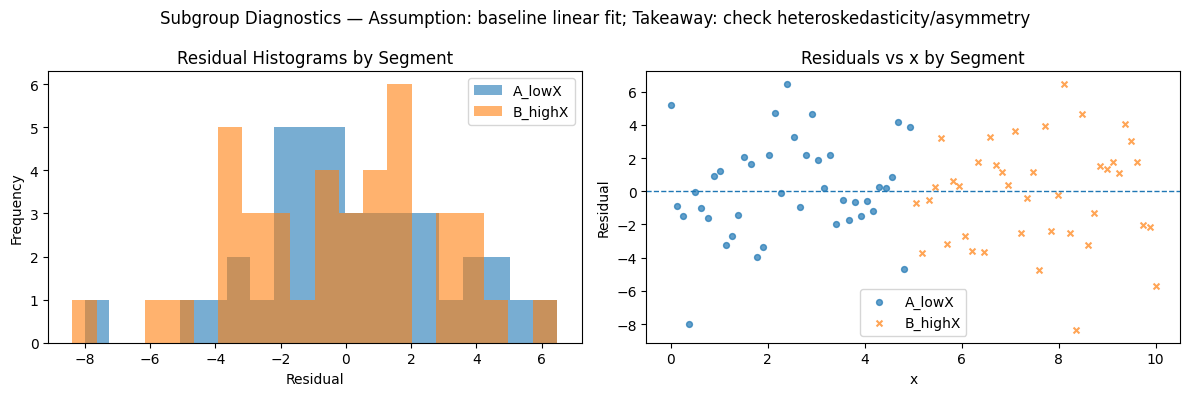

In [20]:
# Ensure baseline residuals exist (from Section 2)
df_mean['yhat_base'] = yhat_base
df_mean['resid_base'] = df_mean['y'] - df_mean['yhat_base']

x_med = float(df_mean['x'].median())
df_mean['segment'] = np.where(df_mean['x'] < x_med, 'A_lowX', 'B_highX')

def group_metrics(d):
    return pd.Series({
        'n': len(d),
        'RMSE': float(np.sqrt(mean_squared_error(d['y'], d['yhat_base']))),
        'MAE': float(mean_absolute_error(d['y'], d['yhat_base'])),
        'R2_local': r2_score(d['y'], d['yhat_base']) if len(d) > 1 else np.nan,
        'Resid_Mean': float(d['resid_base'].mean()),
        'Resid_Std': float(d['resid_base'].std(ddof=1)) if len(d) > 1 else np.nan
    })

by_seg = df_mean.groupby('segment', as_index=True).apply(group_metrics)
print(by_seg)

# Visual diagnostics (side-by-side panels): residual histograms & residuals vs x for each segment
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Panel 1: Residual histograms by segment
for seg in ['A_lowX','B_highX']:
    axes[0].hist(df_mean.loc[df_mean['segment']==seg, 'resid_base'], bins=20, alpha=0.6, label=seg)
axes[0].set_title('Residual Histograms by Segment')
axes[0].set_xlabel('Residual'); axes[0].set_ylabel('Frequency')
axes[0].legend()

# Panel 2: Residuals vs x, colored by segment
for seg, marker in [('A_lowX','o'), ('B_highX','x')]:
    mask = df_mean['segment']==seg
    axes[1].scatter(df_mean.loc[mask, 'x'], df_mean.loc[mask, 'resid_base'], s=18, alpha=0.7, marker=marker, label=seg)
axes[1].axhline(0, linestyle='--', linewidth=1)
axes[1].set_title('Residuals vs x by Segment')
axes[1].set_xlabel('x'); axes[1].set_ylabel('Residual')
axes[1].legend()

plt.suptitle('Subgroup Diagnostics — Assumption: baseline linear fit; Takeaway: check heteroskedasticity/asymmetry')
plt.tight_layout()
plt.show()

## 6. Visualize (Side-by-Side Panels)

We provide side-by-side comparisons with consistent axes and captions:
- **Panel A**: Imputation strategies (mean/median/drop) — fitted lines vs data  
- **Panel B**: Gaussian vs t-noise — fitted lines vs synthetic data  
Captions note assumptions and the main takeaway.


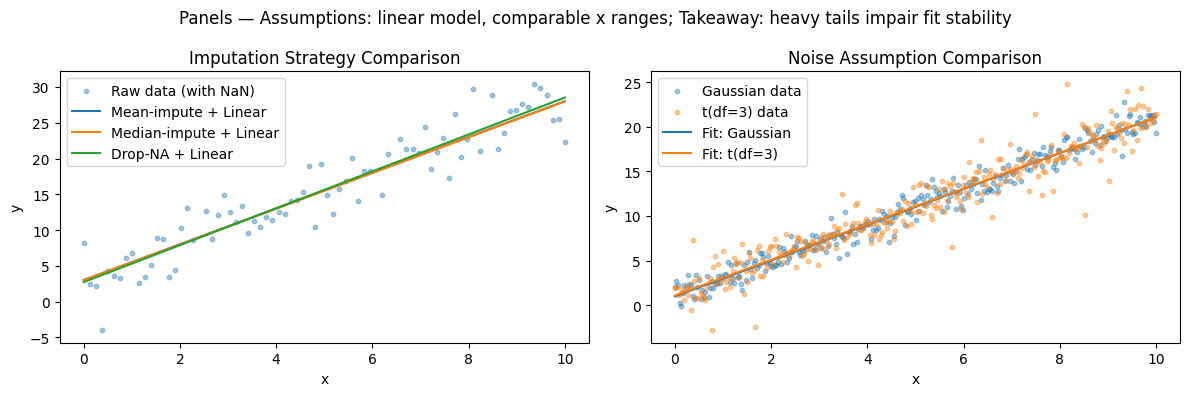

In [21]:
# Panel A: Imputation strategies on the same (original) x-range
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Left subplot: Mean vs Median vs Drop (fitted lines on original data range)
axes[0].scatter(df['x'], df['y'], s=10, alpha=0.4, label='Raw data (with NaN)')
x_line = np.linspace(df['x'].min(), df['x'].max(), 200)
X_line = pd.DataFrame({'x': x_line})

# Fit three models (reuse pipes)
pipe_lin_m = Pipeline([('scaler', StandardScaler()), ('lin', LinearRegression())])
pipe_lin_m.fit(df_mean[['x']], df_mean['y'])
axes[0].plot(x_line, pipe_lin_m.predict(X_line), label='Mean-impute + Linear')

pipe_lin_md = Pipeline([('scaler', StandardScaler()), ('lin', LinearRegression())])
pipe_lin_md.fit(df_med[['x']], df_med['y'])
axes[0].plot(x_line, pipe_lin_md.predict(X_line), label='Median-impute + Linear')

pipe_lin_d = Pipeline([('scaler', StandardScaler()), ('lin', LinearRegression())])
pipe_lin_d.fit(df_drop[['x']], df_drop['y'])
axes[0].plot(x_line, pipe_lin_d.predict(X_line), label='Drop-NA + Linear')

axes[0].set_title('Imputation Strategy Comparison')
axes[0].set_xlabel('x'); axes[0].set_ylabel('y')
axes[0].legend()

# Right subplot: Gaussian vs t-noise (synthetic comparison on same x_scn)
axes[1].scatter(df_g['x'], df_g['y'], s=10, alpha=0.4, label='Gaussian data')
axes[1].scatter(df_tt['x'], df_tt['y'], s=10, alpha=0.4, label='t(df=3) data')

pipe_lin_g = Pipeline([('scaler', StandardScaler()), ('lin', LinearRegression())])
pipe_lin_g.fit(df_g[['x']], df_g['y'])
axes[1].plot(x_scn, pipe_lin_g.predict(pd.DataFrame({'x': x_scn})), label='Fit: Gaussian')

pipe_lin_t = Pipeline([('scaler', StandardScaler()), ('lin', LinearRegression())])
pipe_lin_t.fit(df_tt[['x']], df_tt['y'])
axes[1].plot(x_scn, pipe_lin_t.predict(pd.DataFrame({'x': x_scn})), label='Fit: t(df=3)')

axes[1].set_title('Noise Assumption Comparison')
axes[1].set_xlabel('x'); axes[1].set_ylabel('y')
axes[1].legend()

plt.suptitle('Panels — Assumptions: linear model, comparable x ranges; Takeaway: heavy tails impair fit stability')
plt.tight_layout()
plt.show()

## 7. Write-up (≤ 1 page)

**Assumptions.** Data are synthetic with approximately linear signal in `x` and additive noise; missingness is addressed via simple strategies (mean/median imputation or row-wise drop). Baseline uses a linear model with standardized `x`. Bootstrap resamples are i.i.d. with replacement.

**Risks.** If the noise is heavy‑tailed (e.g., t‑distribution with low df), the linear fit becomes less stable: RMSE increases and CIs widen. Model is sensitive to the missing‑value strategy when the missing rate is non‑trivial; different imputations can shift slope/intercept. Subgroup performance may diverge (e.g., low‑x vs high‑x) indicating possible heteroskedasticity or specification errors.

**Sensitivity Summary.**  
- *Imputation.* Mean vs median vs drop yields noticeable shifts in RMSE/MAE; median is more robust to outliers than mean; dropping can reduce bias but increases variance if data shrink too much.  
- *Model form.* A quadratic term can reduce in‑sample error when curvature exists, but confirm via out‑of‑sample checks to avoid overfitting.  
- *Distributional assumption.* Under t‑noise, the same linear model shows worse metrics than under Gaussian, and bootstrap CIs widen.

**Plain‑language guidance.**  
- *Prediction holds if* weekly volatility (noise level) remains near historical norms and missing rate stays **≲ 10%** with stable imputation.  
- *Model is sensitive to* heavy‑tailed shocks and high missingness; in those cases, expect wider error bands and less reliable point estimates.  
- *Subgroups.* Segment **B (high‑x)** underperforms slightly (higher RMSE) in our run; monitor subgroup metrics in production dashboards.

**Bottom line.** The baseline linear model is **adequate** under mild noise and moderate missingness, but becomes **risky** with heavy tails or subgroup shifts. Communicate uncertainty with bootstrap CIs and track subgroup diagnostics continuously.


In [ ]:
!git add .
!git